## Coordinate-wise optimization

### Package

In [107]:
import scipy.optimize as opt
import numpy as np
from math import *
import matplotlib.pyplot as plt
from DataSet import generateDataSet
from igraph import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
from igraph import *

In [2]:
## Compute the lambdas
def strength(i,j,p,vec):
    summ = 0
    for l in range(p):
        summ += vec[i,l]*vec[j,l]
    return summ

# n : Population / p : Number of communities / k : Number of ranks / a,b : Gamma parameters / w = Community parameter
#/ rho : Data rho[i,j] jth selection of the ith person
def posterior(n,p,k,a,b,w,rho):
    vec = w.reshape((n,p))
    summa = 0
    for i in range(n):
        for u in range(p):
            if vec[i,u] == 0:
                summa += (a-1)*log(0.0000000001) - b*vec[i,u]
            else:
                summa += (a-1)*log(abs(vec[i,u])) - b*vec[i,u]
        totalStrength = 0
        listIndex = [l for l in range(n)]
        del listIndex[i]
        for u in (listIndex):
            totalStrength += strength(i,u,p,vec)
        stateStrength = 0
        for j in range(k):
            totalStrength -= stateStrength
            summa -= log(abs(totalStrength))
            stateStrength = strength(i,rho[i,j],p,vec)
            summa += log(abs(stateStrength))
    return summa

### Test Optimization

In [3]:
n = 40
p = 3
k = 4
a = 2
b = 1
def generateRank(n,k):
    sol = [np.random.choice([j for j in range(i)] + [j for j in range(i + 1,n)], k, replace = False) for i in range(n)]
    return np.array(sol)
rho = generateRank(n,k)
w = 10*np.random.rand(n*p - 1)
print(w)

[0.93241584 5.23914133 2.83897983 1.12719991 8.79306674 9.50474003
 8.76486087 2.38095238 3.86003428 2.22029127 3.02956502 0.85267845
 2.24324409 1.14283692 6.59125573 3.59409528 7.85387877 1.14411104
 6.63992624 5.88242811 5.14059739 4.4854294  4.90585505 4.66855999
 3.69394221 2.90638694 3.87643367 9.76750146 8.13439463 1.4607647
 9.712613   7.09752025 7.13537636 4.74261284 7.1164274  8.14305041
 9.80477758 9.68479705 4.76667484 1.3815318  3.96541466 0.07131272
 0.96561439 1.62652708 4.23648479 7.26258344 2.74229454 9.34123649
 6.04624563 5.61762733 3.4659324  1.38033742 5.75092348 6.87346982
 5.64823461 0.39163687 5.51691672 2.59514421 4.63925294 8.00999568
 2.3304987  4.92244247 5.44028732 1.5260806  5.06547483 8.50257973
 8.07339998 3.73131812 4.1571762  0.59151308 4.93106574 0.88302557
 5.40226246 5.14769527 7.48790963 7.20294108 6.72739541 8.8455555
 9.78512768 8.72778846 8.78029648 9.1711752  6.96155596 7.1233022
 0.31621487 2.88588991 6.21296542 3.67666389 6.98495335 3.2305222

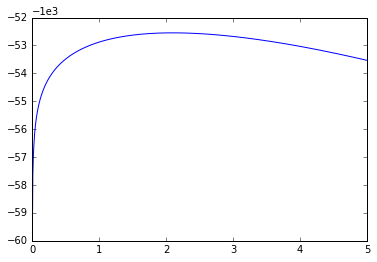

In [4]:
lin1 = np.linspace(0.001,5,750)
yVals = [posterior(n,p,k,a,b,np.insert(w,0,val),rho) for val in lin1]
plt.plot(lin1,yVals)
plt.savefig("CoordinateWiseFunction.png")

### Coordinate Wise Optimization

In [5]:
def optimizeCoor(n,p,k,a,b,rho,eps):
    w = 10*np.random.rand(n*p)
    val = posterior(n,p,k,a,b,w,rho)
    flag = True
    while flag:
        for i in range(n*p):
            w1 = np.delete(w,i)
            funcToOpt = lambda x : (-1)*posterior(n,p,k,a,b,np.insert(w1,i,x),rho)
            res, val1, msg = opt.fmin_l_bfgs_b(funcToOpt, np.array([w[i]]),approx_grad=True, bounds = [(0,+inf)])
            w = np.insert(w1,i,res)
        if abs(val1-val) < eps:
            return w, val1
        else:
            val = val1
        print(val)

### Global Optimization

In [6]:
def globalOpt(n,p,k,a,b,rho):
    w0 = 10*np.random.rand(n*p)
    functionToOpt = lambda w : (-1)*posterior(n,p,k,a,b,w,rho)
    result = opt.fmin_l_bfgs_b(functionToOpt, w0,approx_grad=True, bounds = [(0.000000001, +inf) for i in range(n*p)])
    return result

### Test on simulated Data

#### Data Generation

In [91]:
def drawGamma(a,b,n):
    return np.random.gamma(a,b,n)
def computeStrength(n,p,w):
    w1 = w.reshape((n,p))
    return (np.array([strength(i,j,p,w1) if i != j else 0 for i in range(n) for j in range(n)])).reshape((n,n))
def computeRho(strengths,n,K):
    rho = np.zeros((n,K), dtype = int)
    for i in range(n):
        strength_i = strengths[i]
        strength_i_normalized = (1/(sum(strength_i)))*strength_i
        strength_i_cumulated = [(sum(strength_i_normalized[:(j+1)])) for j in range(n)]
        for j in range(K):
            r = np.random.rand()
            k = 0
            val = strength_i_cumulated[0]
            while r > val:
                k += 1
                val = strength_i_cumulated[k]
            rho[i,j] = k
            strengths[i,k] = 0
            strength_i = strengths[i]
            strengh_i_nomalized = (1/(sum(strength_i)))*strength_i
            strength_i_cumulated = [(sum(strength_i_normalized[:(l+1)])) for l in range(n)]
    return rho
def normalizeStrength(n,strengths):
    for i in range(n):
        strengths[i] = (1/sum(strengths[i]))*strengths[i]
    return strengths

In [92]:
n = 15
p = 3
k = 3
a = 2
b = 1
w = drawGamma(a,b,n*p)
strengths = computeStrength(n,p,w)
rho = computeRho(strengths,n,k)

### Optimization Simulated Data

In [93]:
def AE(w1,w2,n):
    return (sum(map(lambda couple : abs(couple[0]-couple[1]) ,zip(w1,w2))))/n

def rankingGap(w1,w2,n):
    rk1 = [i for i in range(n)]
    rk2 = [i for i in range(n)]
    rk1 = sorted(rk1, key=lambda i: w1[i])
    rk2 = sorted(rk2, key=lambda i: w2[i])
    rk2 = [rk2.index(i) for i in rk1]
    return (sum(map(lambda couple : abs(couple[0]-couple[1]) ,zip(rk1,rk2))))/n

#### Test Coordinate Optimization

In [94]:
eps = 0.000001
result = optimizeCoor(n,p,k,a,b,rho,eps)

160.6505106751766
157.6134488071406
157.3220584610874
157.24772787880835
157.1843148117965
157.06266891526198
156.79827256377402
156.45085977722698
156.25489543340194
156.20165345459924
156.19165024713212
156.189969034528
156.1896803546751
156.18962587905136
156.1896149153208
156.1896122143789


#### Test Global Opti

In [95]:
resultGlobal = globalOpt(n,p,k,a,b,rho)
print(resultGlobal)

(array([0.91092694, 1.29075524, 1.15963435, 0.81478239, 0.53179898,
       1.60430412, 1.12147574, 0.63819704, 0.69545596, 1.5038306 ,
       0.64050768, 0.71668162, 0.54859248, 0.79134044, 0.56654577,
       2.4222091 , 0.60326546, 0.65387181, 1.48019913, 0.52694789,
       1.4835132 , 0.60147485, 0.59869832, 2.90446996, 0.62938831,
       0.56785288, 1.849916  , 0.77723492, 0.60215211, 0.51493884,
       2.82063708, 1.14824109, 0.86188034, 0.33208747, 1.24750926,
       0.34332126, 0.52137055, 2.17447795, 0.42014761, 0.56431998,
       1.41449197, 0.50078595, 0.8540031 , 0.68677673, 1.36025708]), 156.18961189844333, {'grad': array([ 0.00000000e+00, -2.27373675e-05, -8.52651283e-06,  1.08002496e-04,
        1.13686838e-05,  2.84217094e-06, -3.12638804e-05,  1.70530257e-05,
       -1.70530257e-05, -2.50111043e-04,  1.25055521e-04,  5.40012479e-05,
        3.69482223e-05, -1.02318154e-04,  3.41060513e-05,  3.09796633e-04,
       -2.27373675e-05, -6.25277607e-05,  2.33058017e-04,  6.8212

### Result Obtained

#### Plot generated

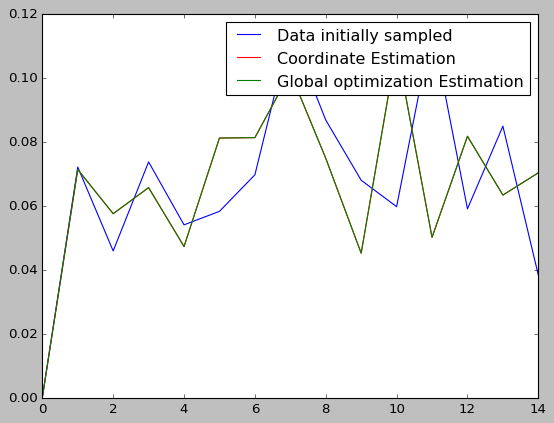

Ranking Gap Coordinate 4.4
Ranking Gap Global 4.4
AE Coordinate 0.020080003780294512
AE Global 0.02008086477737025


In [122]:
numInd = 0
strengthEstimated = normalizeStrength(n,computeStrength(n,p,result[0]))
strengths = normalizeStrength(n,computeStrength(n,p,w))
strengthEstimated = strengthEstimated.reshape((n*n,))
strengths = strengths.reshape((n*n,))
strengthGlb = normalizeStrength(n,computeStrength(n,p,resultGlobal[0]))
strengthGlb = strengthGlb.reshape((n*n,))
plt.plot([i for i in range(n)], strengths[numInd*n:(numInd+1)*n], '-b' ,label = 'Data initially sampled')
plt.plot([i for i in range(n)], strengthEstimated[numInd*n:(numInd+1)*n], '-r' , label = 'Coordinate Estimation')
plt.plot([i for i in range(n)], strengthGlb[numInd*n:(numInd+1)*n], '-g' ,label = 'Global optimization Estimation')
plt.legend()
#plt.title("Estimation of the link between the first individual with the others")
plt.savefig("LambdaEstimation")
plt.show()
print("Ranking Gap Coordinate", rankingGap(strengths[numInd*n:(numInd+1)*n],strengthEstimated[numInd*n:(numInd+1)*n],n))
print("Ranking Gap Global", rankingGap(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))

print("AE Coordinate", AE(strengths[numInd*n:(numInd+1)*n],strengthEstimated[numInd*n:(numInd+1)*n],n))
print("AE Global", AE(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))

#### Graph Comparison

[11, 7, 8, 13, 3, 1, 6, 9, 10, 12, 5, 4, 2, 14, 0]
[7, 11, 8, 0, 6, 13, 5, 3, 9, 10, 4, 12, 2, 14, 1]
[9, 3, 10, 11, 6, 0, 8, 7, 5, 13, 1, 4, 12, 14, 2]
[11, 9, 7, 0, 10, 13, 8, 6, 2, 1, 5, 12, 4, 14, 3]
[7, 11, 8, 0, 6, 5, 9, 3, 1, 10, 13, 2, 12, 14, 4]
[7, 8, 6, 11, 0, 1, 10, 9, 3, 4, 2, 14, 13, 12, 5]
[7, 8, 11, 0, 5, 9, 3, 10, 1, 13, 4, 2, 14, 12, 6]
[11, 8, 0, 13, 1, 6, 5, 3, 4, 12, 9, 10, 14, 2, 7]
[7, 11, 0, 6, 5, 1, 13, 3, 9, 10, 4, 14, 2, 12, 8]
[3, 10, 11, 0, 2, 7, 6, 13, 8, 1, 5, 4, 12, 14, 9]
[9, 3, 11, 6, 7, 2, 8, 0, 5, 13, 1, 4, 12, 14, 10]
[7, 0, 13, 8, 3, 1, 6, 9, 12, 10, 5, 4, 2, 14, 11]
[11, 7, 0, 13, 3, 8, 9, 1, 6, 10, 4, 2, 5, 14, 12]
[11, 7, 0, 3, 9, 8, 1, 12, 10, 6, 4, 2, 5, 14, 13]
[7, 8, 11, 5, 0, 6, 1, 9, 3, 10, 4, 13, 2, 12, 14]


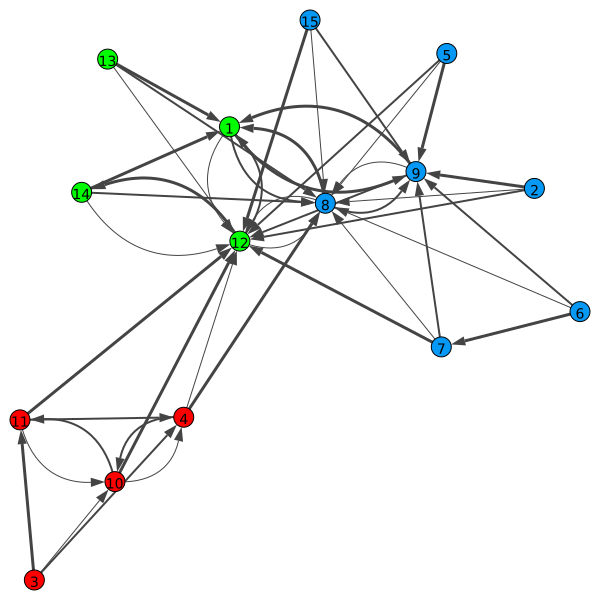

In [109]:
g = Graph(directed=True)
g.add_vertices(n)
comm = w.reshape((n,p))
for i in range(n):
    listToSort = [i for i in range(n)]
    listStrengthOrigin_i = strengths[i*n : (i+1)*n]
    listSorted = sorted(listToSort, key=lambda x: listStrengthOrigin_i[x])
    listSorted.reverse()
    print(listSorted)
    for j in range(k):
        g.add_edge(i,listSorted[j], width=j+1)
g.vs["label"] = [i + 1 for i in range(n)]
colors = ["red", "green", (0.02, 0.6, 0.96)]
g.vs["color"] = [colors[np.argmax(comm[i])] for i in range(n)]
out = plot(g)
out.save("OriginalPlot.png")
out

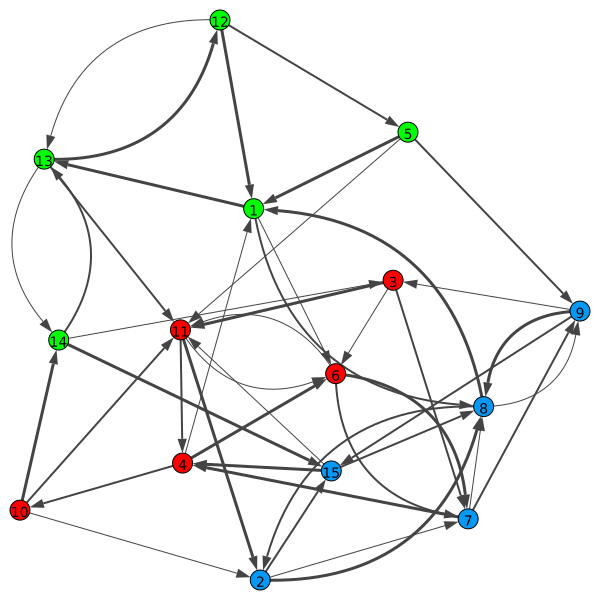

In [112]:
g = Graph(directed=True)
g.add_vertices(n)
for i in range(n):
    for j in range(k):
        g.add_edge(i,rho[i,j], width=j+1)
g.vs["label"] = [i + 1 for i in range(n)]
colors = ["red", "green", (0.02, 0.6, 0.96)]
g.vs["color"] = [colors[np.argmax((resultGlobal[0].reshape((n,p)))[i])] for i in range(n)]
out = plot(g)
out.save("OptimizationPlot.png")
out